In [3]:
'''
This notebook performs statistics on patterns and similar entry/exit signals. What is the probabability that the closing price will be higher/lower than when the signal appeared after "lag" day in the future?
'''
import sys
sys.path.append("..")

from core.data_manager import retrieve_data_offline 
from core import indicators as ic
from core import strat, constants
from core.common import remove_multi
import vectorbtpro as vbt
import gc
import numbers

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

In [4]:
PATTERNS=["CDL2CROWS", "CDL3BLACKCROWS", "CDL3INSIDE", "CDL3LINESTRIKE",
          "CDL3OUTSIDE", "CDL3STARSINSOUTH", "CDL3WHITESOLDIERS",
          "CDLABANDONEDBABY","CDLADVANCEBLOCK", "CDLBELTHOLD",
          "CDLBREAKAWAY", "CDLCLOSINGMARUBOZU", "CDLCONCEALBABYSWALL",
          "CDLCOUNTERATTACK", "CDLDARKCLOUDCOVER", "CDLDOJI",
          "CDLDOJISTAR", "CDLDRAGONFLYDOJI", "CDLENGULFING", 
          "CDLEVENINGDOJISTAR", "CDLEVENINGSTAR", "CDLGAPSIDESIDEWHITE",
          "CDLGRAVESTONEDOJI", "CDLHAMMER", "CDLHANGINGMAN", "CDLHARAMI",
          "CDLHARAMICROSS", "CDLHIGHWAVE", "CDLHIKKAKE", "CDLHIKKAKEMOD",
          "CDLHOMINGPIGEON", "CDLIDENTICAL3CROWS", "CDLINNECK",
          "CDLINVERTEDHAMMER", "CDLKICKING", "CDLKICKINGBYLENGTH",
          "CDLLADDERBOTTOM", "CDLLONGLEGGEDDOJI", "CDLLONGLINE",
          "CDLMARUBOZU", "CDLMATCHINGLOW", "CDLMATHOLD", "CDLMORNINGDOJISTAR",
          "CDLMORNINGSTAR", "CDLONNECK", "CDLPIERCING", "CDLRICKSHAWMAN",
          "CDLRISEFALL3METHODS", "CDLSEPARATINGLINES", "CDLSHOOTINGSTAR",
          "CDLSHORTLINE", "CDLSPINNINGTOP", "CDLSTALLEDPATTERN",
          "CDLSTICKSANDWICH", "CDLTAKURI", "CDLTASUKIGAP","CDLTHRUSTING",
          "CDLTRISTAR","CDLUNIQUE3RIVER","CDLUPSIDEGAP2CROWS",
          "CDLXSIDEGAP3METHODS"
          ]

def pattern(
        open_: np.array,
        high: np.array,
        low: np.array,
        close: np.array,
        f_name: str,
        )-> (np.array, np.array): 
    return ic.func_name_to_res(f_name, open_, high, low, close)

VBTPATTERN2 = vbt.IF(
      class_name='VBTPattern',
      short_name='pattern',
      input_names=['open_','high', 'low', 'close'],
      param_names=['f_name'],
      output_names=['out']
 ).with_apply_func(
      pattern, 
      takes_1d=True,  
 )

In [5]:
class STATS():
    def __init__(
            self,
            period: str,
            indexes: list=["CAC40", "DAX", "NASDAQ"], #,"NYSE",,"FIN","HEALTHCARE","IT"
            ):
        '''
        Class to perform statistics on pattern and signals.
        
        Estimate what is the chance that a price will increase/decrease x days after pattern/signal occurrence.
        
        Arguments
        ----------
            symbol_index: main index to be retrieved
            indexes: main indexes used to download local data
        '''
        #init
        for k in ["indexes"]:
            setattr(self,k,locals()[k])
        
        for key in ["close","open","low","high","data","volume"]:
            setattr(self,key+"_dic",{})
            setattr(self,key+"_ind_dic",{})

        for ind in self.indexes:
            retrieve_data_offline(self,ind,period)                
            self.data_dic[ind]=self.data
            for d in ["Close","Open","Low","High","Volume"]:
                getattr(self,d.lower()+"_dic")[ind]=self.data_dic[ind].get(d)   
                getattr(self,d.lower()+"_ind_dic")[ind]=self.data_ind.get(d)   
    
    def prepare(
        self,
        pattern:bool=True, 
        lag:int=1
    ):
        '''
        Calculate the signals and flatten it
        
        Arguments
        ----------
            pattern: estimate the patterns if true, the signals otherwise (see function defi_x)
            lag: compare the price in "lag" days to today. 
        '''
        self.defi_x(pattern=pattern,lag=lag)
        self.flatten()
        print("prepare finished")
    
    def save(self,data_name:str):
        '''
        Save the prepared data
        
        Arguments
        ----------
            data_name: name of the data for saving        
        '''
        self.x_df.to_csv("x_"+data_name+".csv")
   
    def defi_x(
        self,
        pattern:bool=True,
        lag:int=1 #compare the price now with lag days in the past, must be at least 1
    ):
        '''
        Calculate the signals
        Don't hesitate to add/remove/comment signals
        
        Arguments
        ----------
            pattern: estimate the patterns if true, the signals otherwise (see function defi_x)
            lag: compare the price in "lag" days to today. 
        '''        
        self.all_x={}
        
        for ind in self.indexes: #CAC, DAX, NASDAQ
            all_x={}
            open_=self.open_dic[ind].shift(lag)
            high=self.high_dic[ind].shift(lag)
            low=self.low_dic[ind].shift(lag)
            close=self.close_dic[ind].shift(lag)
            close_ind=self.close_ind_dic[ind].shift(lag)
            volume=self.volume_dic[ind].shift(lag)
            
            if pattern:
                for f_name in PATTERNS:
                    all_x[f_name]=VBTPATTERN2.run(open_,high,low,close,f_name).out
            else:
                '''
                t=ic.VBTSTOCHKAMA.run(high,low,close)
                all_x['STOCH_ent']=t.entries_stoch
                all_x['STOCH_ex']=t.exits_stoch

                all_x['KAMA_ent']=t.entries_kama
                all_x['KAMA_ex']=t.exits_kama

                t=ic.VBTSUPERTREND.run(high,low,close)
                all_x['SUPERTREND_ent']=t.entries
                all_x['SUPERTREND_ex']=t.exits

                t=vbt.BBANDS.run(close)
                all_x['BBANDS_ent']=t.lower_above(close)
                all_x['BBANDS_ex']=t.upper_below(close)

                t=vbt.RSI.run(close,wtype='simple')
                all_x['RI20_ent']=t.rsi_crossed_below(20)
                all_x['RI20_ex']=t.rsi_crossed_above(80)

                all_x['RI30_ent']=t.rsi_crossed_below(30)
                all_x['RI30_ex']=t.rsi_crossed_above(70)
                '''
                t=ic.VBTWILLR.run(high,low, close)
                all_x["WILLR10_ent"]=t.out_crossed_below(-90)
                all_x["WILLR10_ex"]=t.out_crossed_above(-10)
                all_x["WILLR20_ent"]=t.out_crossed_below(-80)
                all_x["WILLR20_ex"]=t.out_crossed_above(-20)
                '''
                t=vbt.talib("ADX").run(high,low,close)
                all_x["ADX10_ent"]=t.real_crossed_below(10)
                all_x["ADX15_ent"]=t.real_crossed_below(15)
                all_x["ADX35_ex"]=t.real_crossed_above(35)
                all_x["ADX40_ex"]=t.real_crossed_above(40)
                
                t=vbt.talib("ADXR").run(high,low,close)
                all_x["ADXR10_ent"]=t.real_crossed_below(10)
                all_x["ADXR15_ent"]=t.real_crossed_below(15)
                all_x["ADXR35_ex"]=t.real_crossed_above(35)
                all_x["ADXR40_ex"]=t.real_crossed_above(40)
                
                t=vbt.talib("APO").run(close)
                all_x["APO_ent"]=t.real_crossed_above(0)
                all_x["APO_ex"]=t.real_crossed_below(0)

                t=vbt.talib("AROON").run(high, low)
                all_x["AROONUP_ent"]=t.aroonup_crossed_above(50)
                all_x["AROONDOWN_ent"]=t.aroondown_crossed_below(50)
                all_x["AROONUP_ex"]=t.aroonup_crossed_below(50)
                all_x["AROONDOWN_ex"]=t.aroondown_crossed_above(50)
                
                all_x["AROON_ent"]=t.aroondown_crossed_below(t.aroonup)
                all_x["AROON_ex"]=t.aroondown_crossed_above(t.aroonup)
                
                t=ic.VBTMA.run(close)
                all_x["MA_ent"]=t.entries #5/15
                all_x["MA_ex"]=t.exits
                
                fast_ma = vbt.MA.run(close, 10)
                slow_ma = vbt.MA.run(close, 30)
                all_x["MA1030_ent"]=fast_ma.ma_crossed_above(slow_ma)
                all_x["MA1030_ex"]=fast_ma.ma_crossed_below(slow_ma)
               
                macd=vbt.MACD.run(close, macd_wtype='simple',signal_wtype='simple')
                all_x["hist_ent"]=macd.hist_crossed_above(0)
                all_x["hist_ex"]=macd.hist_crossed_below(0)

                all_x["macd_ent"]=macd.macd_crossed_above(0)
                all_x["macd_ex"]=macd.macd_crossed_below(0)
                
                t=vbt.talib("AROONOSC").run(high, low)
                all_x["AROONOSC_ent"]=t.real_crossed_above(0)
                all_x["AROONOSC_ex"]=t.real_crossed_below(0)
                
                t=vbt.talib("BOP").run(open_, high, low, close)
                all_x["BOP_ent"]=t.real_crossed_above(0)
                all_x["BOP_ex"]=t.real_crossed_below(0)
                
                t=vbt.talib("CCI").run(high, low, close)
                all_x["CCI_ent_100"]=t.real_crossed_above(100)
                all_x["CCI_ent_-100"]=t.real_crossed_above(-100)
                all_x["CCI_ex_100"]=t.real_crossed_below(100)
                all_x["CCI_ex_-100"]=t.real_crossed_below(-100)

                t=vbt.talib("CMO").run(close)
                all_x["CMO_ent"]=t.real_crossed_above(0)
                all_x["CMO_ex"]=t.real_crossed_below(0)
 
                t=vbt.talib("MFI").run(high, low, close, volume)
                all_x['MFI20_ent']=t.real_crossed_below(20)
                all_x['MFI20_ex']=t.real_crossed_above(80)
                
                t=vbt.talib("MOM").run(close)
                all_x["MOM_ent"]=t.real_crossed_above(0)
                all_x["MOM_ex"]=t.real_crossed_below(0)
                
                t=vbt.talib("PPO").run(close)
                all_x["PPO_ent"]=t.real_crossed_above(0)
                all_x["PPO_ex"]=t.real_crossed_below(0)

                t=vbt.talib("ULTOSC").run(high, low, close)
                all_x['ULTOSC20_ent']=t.real_crossed_below(20)
                all_x['ULTOSC20_ex']=t.real_crossed_above(80)
                all_x['ULTOSC25_ent']=t.real_crossed_below(25)
                all_x['ULTOSC25_ex']=t.real_crossed_above(75)
                all_x['ULTOSC30_ent']=t.real_crossed_below(30)
                all_x['ULTOSC30_ex']=t.real_crossed_above(70)
                
                t=vbt.talib("HT_TRENDMODE").run(close)
                all_x['HT_TRENDMODE_ent']=t.integer_crossed_above(0.5)
                all_x['HT_TRENDMODE_ex']=t.integer_crossed_below(0.5)
                
                t=vbt.talib("HT_SINE").run(close)
                all_x['HT_SINE_ent']=t.sine_crossed_above(t.leadsine)
                all_x['HT_SINE_ex']=t.sine_crossed_below(t.leadsine)

                t=ic.VBTDIVERGENCE.run(close, close_ind)
                all_x['DIVERGENCE0003_ent']=(t.out<-0.003)
                all_x['DIVERGENCE0004_ent']=(t.out<-0.004)
                all_x['DIVERGENCE0005_ent']=(t.out<-0.005)
                all_x['DIVERGENCE0006_ent']=(t.out<-0.006)
                all_x['DIVERGENCE0007_ent']=(t.out<-0.007)
                all_x['DIVERGENCE0008_ent']=(t.out<-0.008)
                all_x['DIVERGENCE0009_ent']=(t.out<-0.009)
                all_x['DIVERGENCE0010_ent']=(t.out<-0.010)
                '''
            all_x["delta"]=np.divide(self.close_dic[ind],self.close_dic[ind].shift(lag))-1 #close is already shifted, here supplementary days
            all_x["bull"]=(all_x["delta"]>0).astype(int)
            all_x["very_bull"]=(all_x["delta"]>0.02).astype(int)
            all_x["very_bear"]=(all_x["delta"]<-0.02).astype(int)
            
            self.all_x[ind]=all_x          
        gc.collect()

    def create_empty_x_df(self, ind, s):
        '''
        Create an empty Multiindex (timestamp, ticker, stock exchange index)
        
        Arguments
        ----------
            ind: main index used for instance "CAC40"
            s: symbol, ticker of the stock
        '''
        return pd.MultiIndex.from_arrays([
            self.close_dic[ind].index,  #list(
            [s for ii in self.close_dic[ind].index],
            [ind for ii in self.close_dic[ind].index]
        ])
        
    def flatten(
        self
        ):
        input_arr=self.all_x
        df_total=None
        ts={}
        '''
        Flatten the data
        '''        
        #remove the multiindex only once
        for ind in self.indexes: #CAC, DAX, NASDAQ    
            ts[ind]={}
            for col in input_arr[ind]:
                ts[ind][col]=remove_multi(input_arr[ind][col])
           
        #we revert columns and rows, quite expensive operation
        for ind in self.indexes: #CAC, DAX, NASDAQ
            for s in self.close_dic[ind].columns:
                dfs=[]
                for col in input_arr[ind]:
                    dfs.append(ts[ind][col][s].rename(col))
                #put columns together
                df=pd.concat(dfs,axis=1)
                #clean
                df=df.fillna(0)
                df=df.replace([np.inf, -np.inf], 0)   
                #get the index
                df.set_index(self.create_empty_x_df(ind,s) ,inplace=True)
                
                #put rows together
                df_total=pd.concat([df_total,df])
        self.x_df=df_total
    
    def summarize(self):
        '''
        Calculate statistics for the pattern/signal. For one "compare the price in "lag" days to today"
        '''
        summary={"value":{},"Nb":{},"bull":{}, "percent":{},"very_percent":{}}        
        
        for c in self.x_df.columns:
            if c not in ["delta","bull",'very_bull', 'very_bear']:
                sub_df=self.x_df[self.x_df[c]!=0]
                all_v=sub_df[c].unique()
                
                for v in all_v:
                    sub_df2=sub_df[sub_df[c]==v]
                    
                    summary["value"][c]=v
                    summary["Nb"][c]=sub_df2[c].count()
                    nb=summary["Nb"][c]
                    t=sub_df2["bull"].sum()
                    
                    if t/nb > 0.5:
                        summary["bull"][c]=True
                        summary["percent"][c]=t/nb
                        summary["very_percent"][c]=sub_df2["very_bull"].sum()/nb
                    else:
                        summary["bull"][c]=False
                        summary["percent"][c]=1-t/nb
                        summary["very_percent"][c]=sub_df2["very_bear"].sum()/nb
                    
        self.summary=pd.DataFrame(data=summary)
        return self.summary
        
    def total_summarize(
        self,
        pattern:bool=True,
        max_lag:int=15,
        display_deviation: bool=False
    ):
        '''
        Calculate statistics for the pattern/signal. For several "compare the price in "lag" days to today", between 1 and max_lag.
        
        Arguments
        ----------
            pattern: estimate the patterns if true, the signals otherwise (see function defi_x)
            max_lag: compare the price in "lag" days to today. Here the statistics will be calculated between 1 and max_lag.
            display_deviation: Keep in mind that the bull/bear ratio of the set is not 50%. It is 51% bull on one day, and 56% bull on 5 days 
                               (so 56% of the stocks price is higher after 5 days, and 44% lower). 
                               To avoid this effect, use display_deviation. It will substract this average from the value displayed.
        '''
        if pattern:
            summary={"value":{},"Nb":{},"pattern":{}}
        else:
            summary={"value":{},"Nb":{}}
                 
        for lag in range(1,max_lag+1):
            self.prepare(pattern=pattern,lag=lag)
            if display_deviation:
                col_name="bull_deviation_"+str(lag)+"_day_after"
            else:
                col_name="bull_"+str(lag)+"_day_after"
            summary[col_name]={}
            mean_bull=self.x_df["bull"].sum()/self.x_df["bull"].count()
            
            for c in self.x_df.columns:
                if c not in ["delta","bull",'very_bull', 'very_bear']:
                    sub_df=self.x_df[self.x_df[c]!=0]
                    all_v=sub_df[c].unique()
                
                    for v in all_v:
                        if pattern:
                            dic_col=c+"_"+str(v)
                        else:
                            dic_col=c #already clear
                            
                        sub_df2=sub_df[sub_df[c]==v]
                        
                        if pattern:
                            summary["pattern"][dic_col]=c
                        summary["value"][dic_col]=v
                        summary["Nb"][dic_col]=sub_df2[c].count()
                        nb=summary["Nb"][dic_col]
                        t=sub_df2["bull"].sum()
                        summary[col_name][dic_col]=t/nb
                        if display_deviation:
                            summary[col_name][dic_col]-=mean_bull
                        
        self.total_summary=pd.DataFrame(data=summary)
        return self.total_summary                    
    

In [6]:
period="2007_2023_08"

In [7]:
m=STATS(period)

  0%|          | 0/40 [00:00<?, ?it/s]

number of days retrieved: 4238


  0%|          | 0/32 [00:00<?, ?it/s]

number of days retrieved: 4201


  0%|          | 0/71 [00:00<?, ?it/s]

number of days retrieved: 4172


In [52]:
#To calculate the statistics for prevision for "lag" days in the future
m.prepare(pattern=False, lag=1)
m.summarize()


prepare finished


,value,Nb,bull,percent,very_percent
AROONOSC_ent,True,20085,True,0.513966,0.115758
AROONOSC_ex,True,20067,True,0.507101,0.125131
BOP_ent,True,145785,True,0.506712,0.120122
BOP_ex,True,145781,True,0.515417,0.118150
CCI_ent_100,True,39886,True,0.504087,0.105501
CCI_ent_-100,True,32142,True,0.514343,0.139755
CCI_ex_100,True,39858,True,0.512193,0.103517
CCI_ex_-100,True,32124,True,0.521510,0.139086
CMO_ent,True,33548,True,0.507392,0.116371
CMO_ex,True,33520,True,0.513753,0.124911


In [9]:
#To calculate the statistics for prevision for "lag" days in the future between 1 and max_lag

#Keep in mind that the bull/bear ratio of the set is not 50%. It is 51% bull on one day, and 56% bull on 5 days (so 56% of the stocks price is higher after 5 days, and 44% lower). 
#To avoid this effect, use display_deviation. It will substract this average from the value displayed.
m.total_summarize(pattern=False, max_lag=15, display_deviation=True)

prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished
prepare finished


,value,Nb,bull_1_day_after,bull_2_day_after,bull_3_day_after,bull_4_day_after,bull_5_day_after,bull_6_day_after,bull_7_day_after,bull_8_day_after,bull_9_day_after,bull_10_day_after,bull_11_day_after,bull_12_day_after,bull_13_day_after,bull_14_day_after,bull_15_day_after
WILLR10_ent,True,37413,0.023722,0.017893,0.019265,0.025573,0.022237,0.021054,0.017460,0.015920,0.016438,0.019563,0.020174,0.019592,0.020042,0.020996,0.023595
WILLR10_ex,True,50176,-0.014357,-0.012848,-0.015693,-0.020346,-0.017936,-0.021792,-0.017115,-0.014357,-0.013442,-0.008131,-0.010765,-0.010562,-0.011091,-0.011199,-0.010317
WILLR20_ent,True,51231,0.013692,0.011265,0.011697,0.018903,0.017834,0.014849,0.014038,0.013240,0.013162,0.014626,0.014511,0.014421,0.013847,0.014914,0.015684
WILLR20_ex,True,60791,-0.010812,-0.007512,-0.008585,-0.013437,-0.015734,-0.015575,-0.011365,-0.011307,-0.009221,-0.006392,-0.008757,-0.007348,-0.008863,-0.011249,-0.010711


In [29]:
#save
total_summary2.to_csv("stats.csv")

In [49]:
#filter
ref_col="bull_5_day_after"
s_bull=m.total_summary[m.total_summary[ref_col]>0.5]
s_bear=m.total_summary[m.total_summary[ref_col]<0.5]

In [51]:
#display
#s_bull.sort_values(by=[ref_col],ascending=False)#.head(20)
s_bear.sort_values(by=[ref_col],ascending=True).head(20)

,value,Nb,bull_1_day_after,bull_2_day_after,bull_3_day_after,bull_4_day_after,bull_5_day_after,bull_6_day_after,bull_7_day_after,bull_8_day_after,bull_9_day_after,bull_10_day_after,bull_11_day_after,bull_12_day_after,bull_13_day_after,bull_14_day_after,bull_15_day_after


In [8]:
#Plot
total_sum=m.total_summary.iloc[:,3:] #remove Nb and value
x=[ii for ii in range(1,16)]

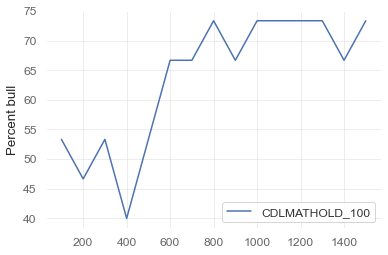

In [173]:
cols=[
"CDLMATHOLD_100",
]

for col in cols:
    plt.plot(x,100*total_sum.loc[col].values,label=col)
plt.ylabel("Percent bull")    
plt.legend()
plt.show()

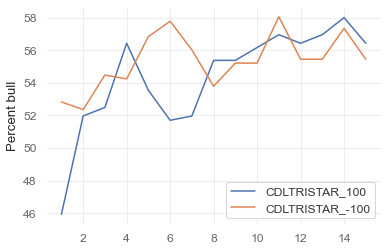

In [9]:
#cols=[
#"CDLHIKKAKE_-200",
#"CDLENGULFING_-100",
#"CDLCLOSINGMARUBOZU_-100",
#"CDLBREAKAWAY_-100",    
#"CDLBREAKAWAY_100",
#"CDLEVENINGSTAR_-100",
#"CDLRISEFALL3METHODS_-100"
#]

cols=[
"CDLTRISTAR_100",
"CDLTRISTAR_-100",    
]

for col in cols:
    plt.plot(x,100*total_sum.loc[col].values,label=col)
plt.ylabel("Percent bull")
plt.legend()
plt.show()